## Spices Image Classification using EfficientNetB0
### Hazel Pernanda Putra

### 1. Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Model

### 2. Load and Visualize Dataset

In [2]:
# Define dataset path
dataset_path = 'Rempah_Dataset'
rempah_types = os.listdir(dataset_path)

# Count images per class
for rempah_type in rempah_types:
    folder_path = os.path.join(dataset_path, rempah_type)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg','webp'))]
        print(f"{rempah_type} folder contains {len(image_files)} images.")

jahe folder contains 605 images.
kencur folder contains 568 images.
kunyit folder contains 591 images.
lengkuas folder contains 531 images.


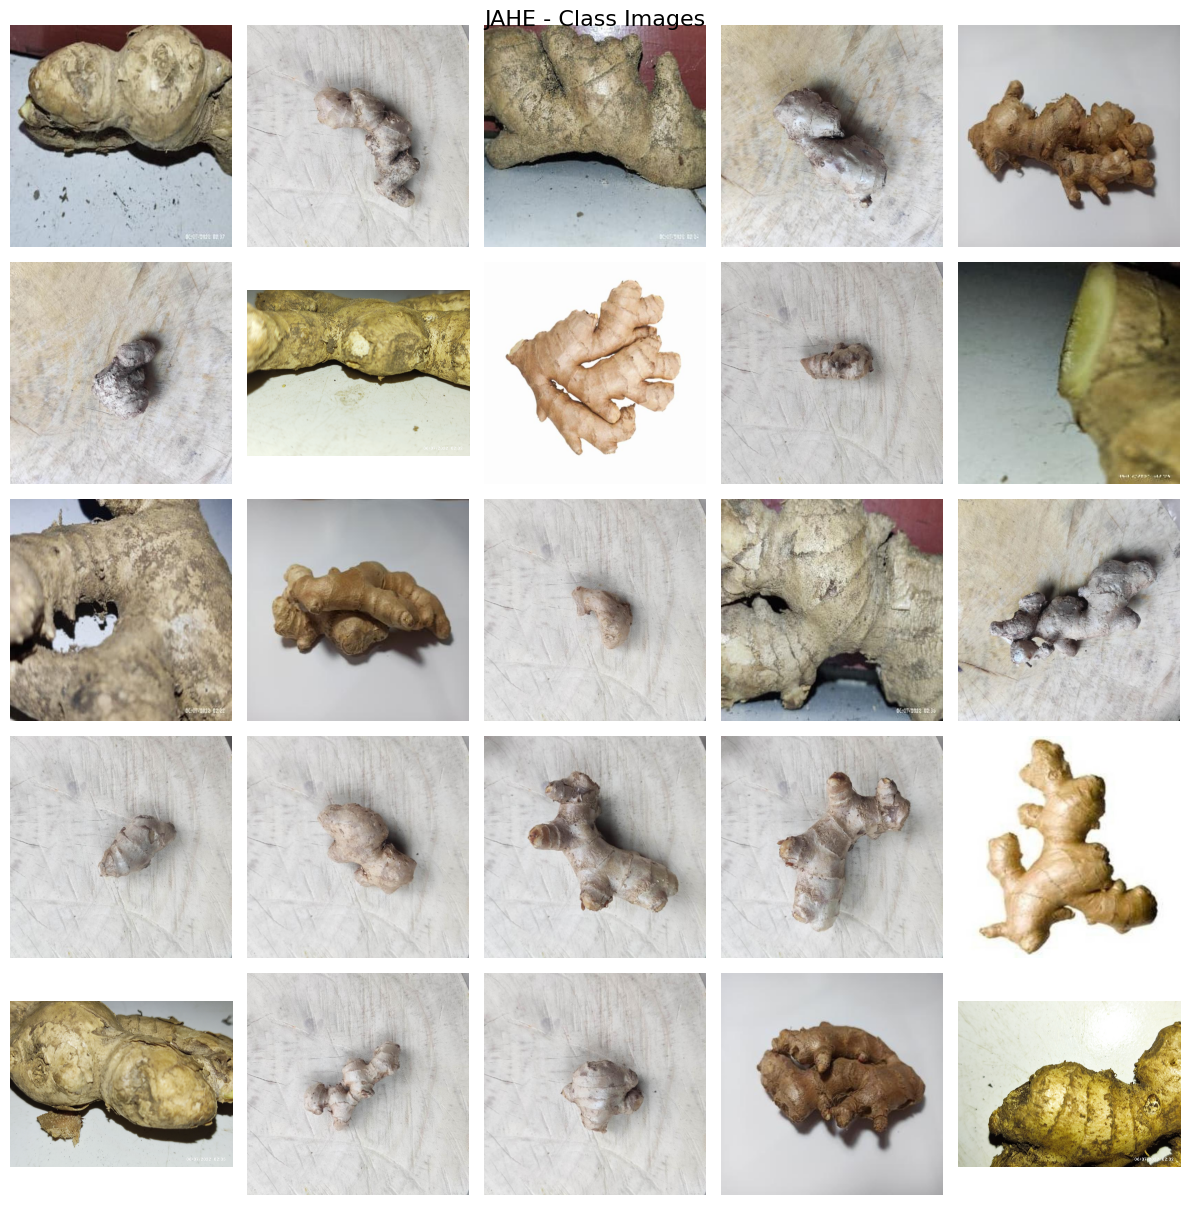

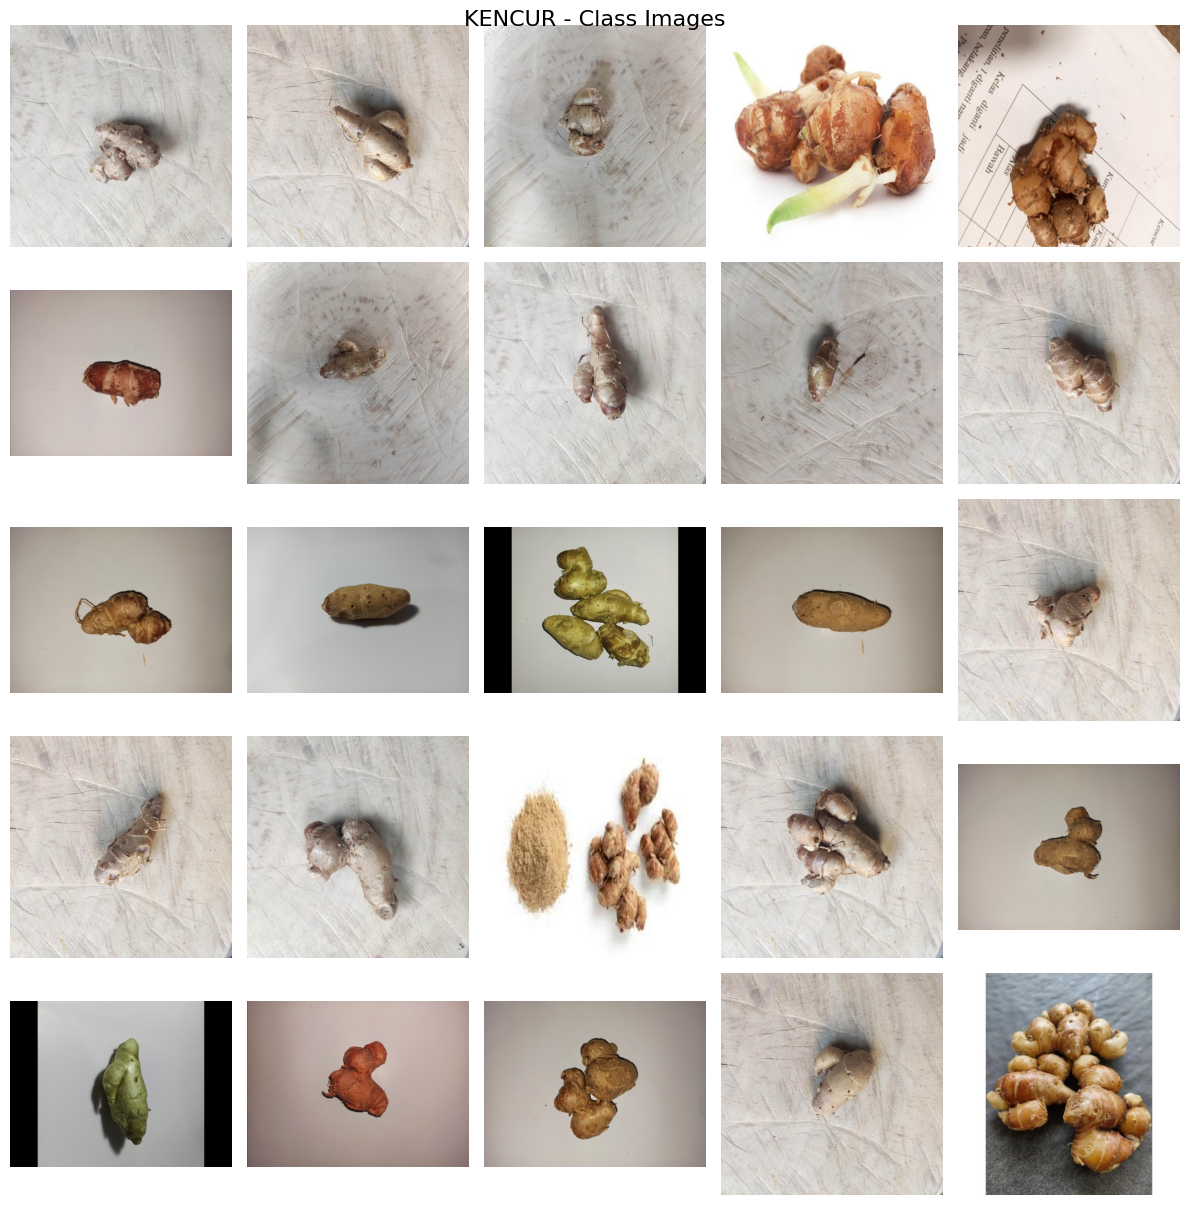

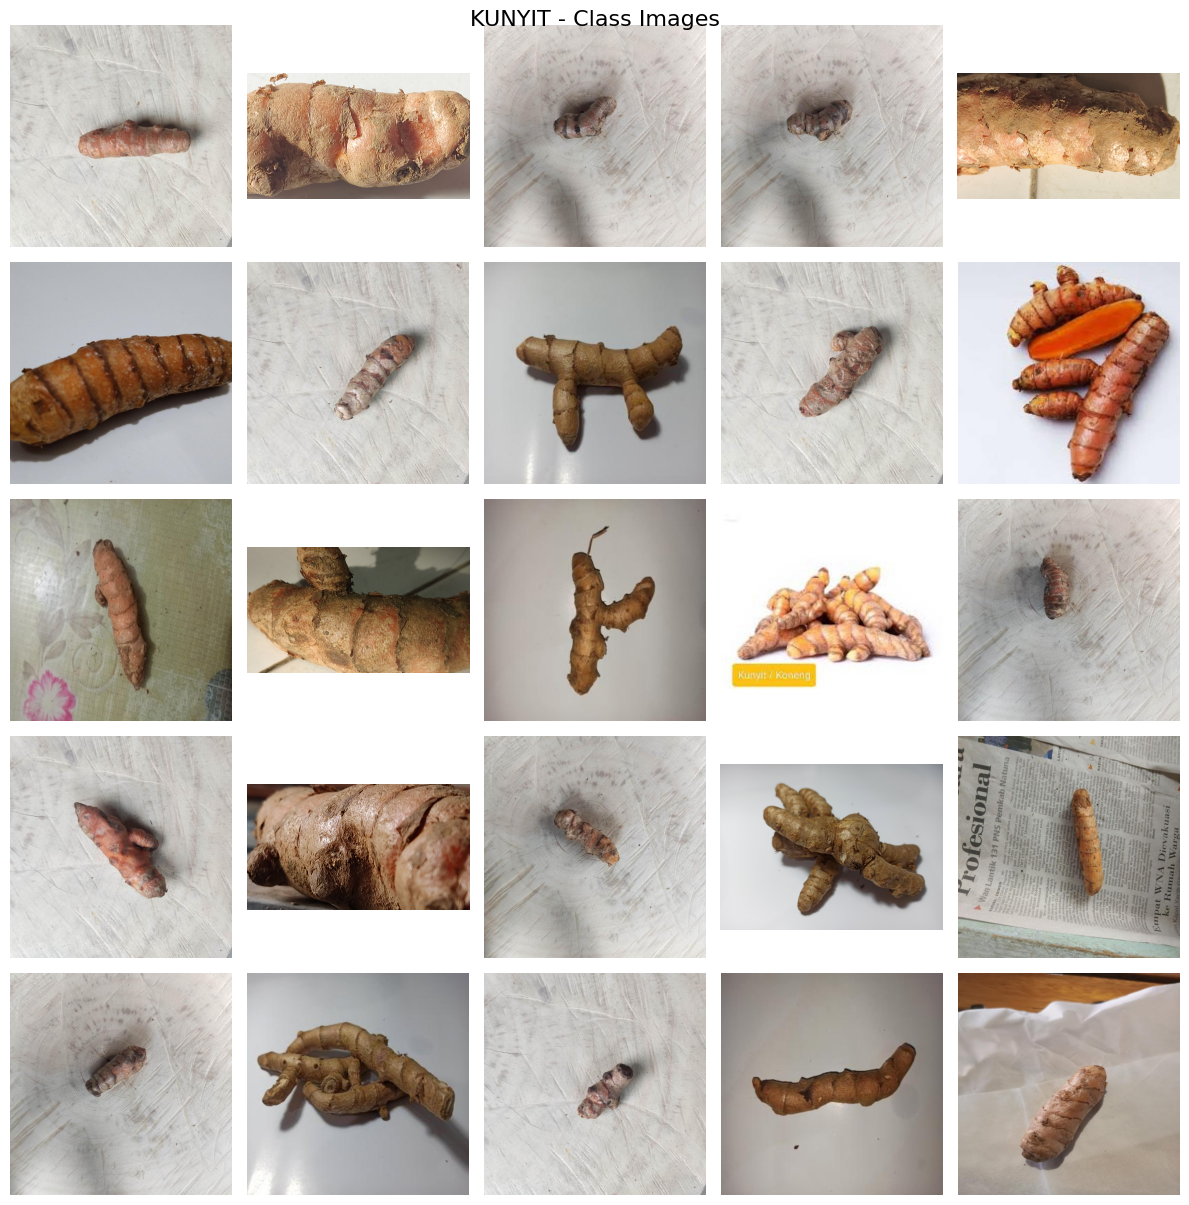

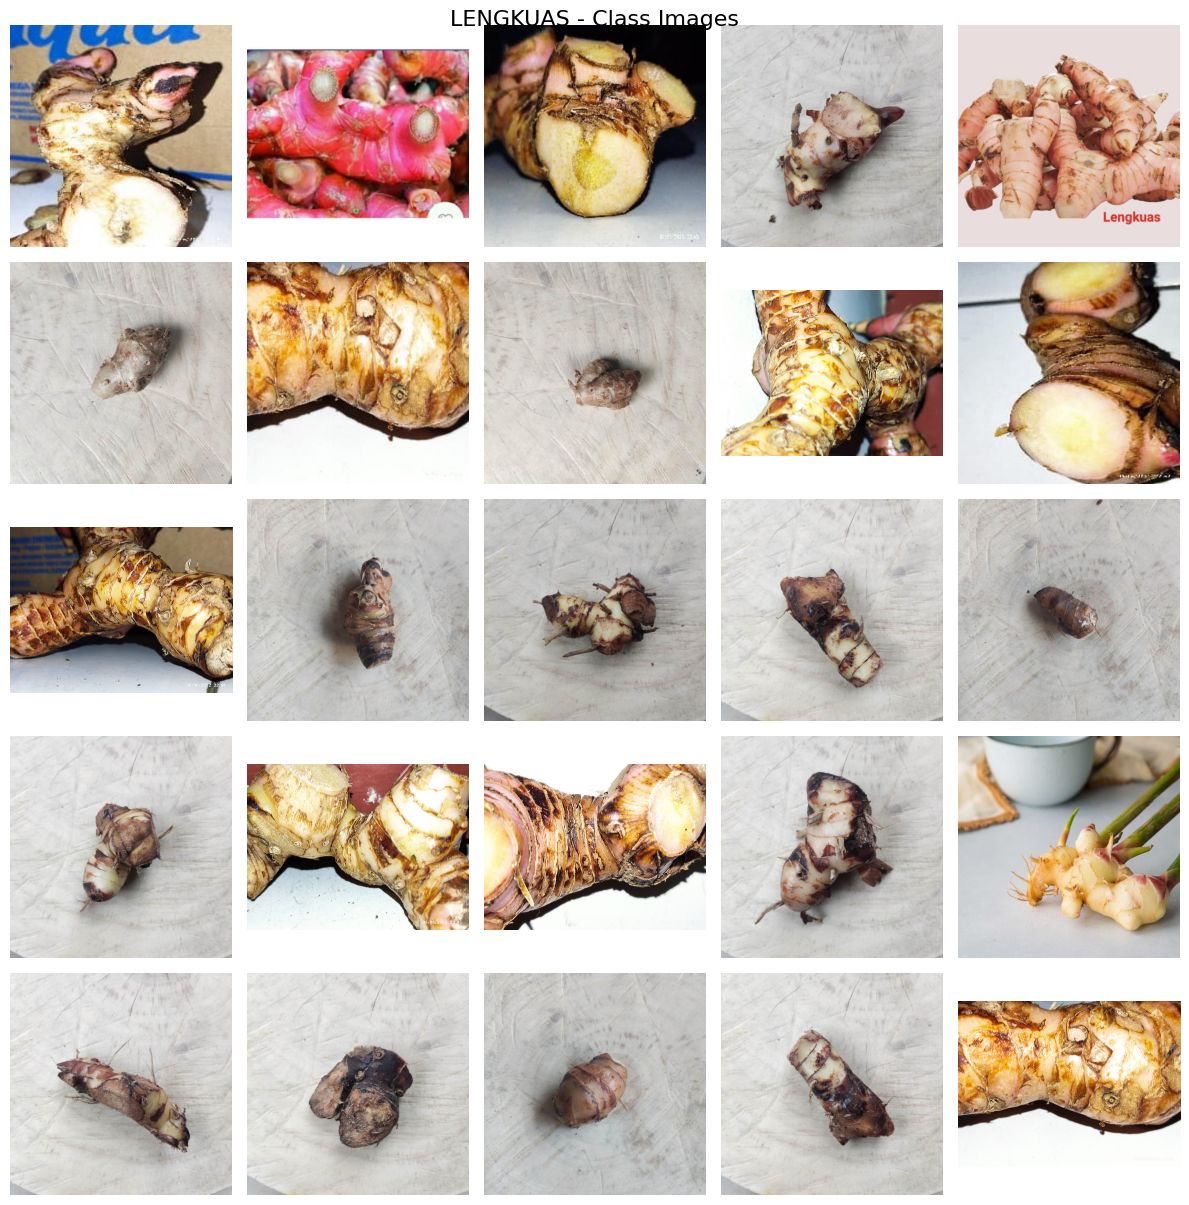

In [4]:
# Visualize 5x5 grid for each class
for rempah_type in rempah_types:
    folder_path = os.path.join(dataset_path, rempah_type)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg','webp'))]
        image_files = random.sample(image_files, min(25, len(image_files)))
        
        fig, axs = plt.subplots(5, 5, figsize=(12, 12))
        axs = axs.flatten()
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
        for i in range(len(image_files), 25):
            axs[i].axis('off')
        
        plt.tight_layout()
        fig.suptitle(f'{rempah_type.upper()} - Class Images', fontsize=16, y=1.00)
        plt.show()

### 3. Data Preprocessing

In [5]:
# Create DataFrame with file paths and labels
data = []
for rempah_type in rempah_types:
    for file in os.listdir(os.path.join(dataset_path, rempah_type)):
        data.append((os.path.join(dataset_path, rempah_type, file), rempah_type))

df = pd.DataFrame(data, columns=['filepath', 'label'])
print(df.head())

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

                                            filepath label
0  Rempah_Dataset\jahe\0907114d-fa32-4f84-8d9d-a6...  jahe
1  Rempah_Dataset\jahe\136551_jpg.rf.49e954bcb3ba...  jahe
2  Rempah_Dataset\jahe\136558_jpg.rf.5bdd42453952...  jahe
3  Rempah_Dataset\jahe\136560_jpg.rf.88466e05846d...  jahe
4  Rempah_Dataset\jahe\25523857-609f-4ac9-b6f2-30...  jahe


In [6]:
# Create data generators
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label',
    target_size=TARGET_SIZE, color_mode='rgb', class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=True, seed=42, subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df, x_col='filepath', y_col='label',
    target_size=TARGET_SIZE, color_mode='rgb', class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=True, seed=42, subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, x_col='filepath', y_col='label',
    target_size=TARGET_SIZE, color_mode='rgb', class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)

Found 1468 validated image filenames belonging to 4 classes.
Found 366 validated image filenames belonging to 4 classes.
Found 459 validated image filenames belonging to 4 classes.


In [13]:
# Data Augmentation
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
])

### 4. Model Architecture

In [14]:
# Load pretrained EfficientNetB0
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False
print(f"EfficientNetB0 loaded with {len(pretrained_model.layers)} layers")


16705208/16705208 [==============================] - 5s 0us/step
EfficientNetB0 loaded with 239 layers


In [15]:
# Build model
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu', name='dense1')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu', name='dense2')(x)
x = Dropout(0.45)(x)
outputs = Dense(4, activation='softmax', name='classification')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()


Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['normaliz

### 6. Training

In [16]:
# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    "rempah_classification_model_checkpoint",
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [18]:
# Train model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/100
46/46 [==============================] - 40s 868ms/step - loss: 1.2254 - accuracy: 0.5054 - val_loss: 0.8274 - val_accuracy: 0.6858 - lr: 1.0000e-04
Epoch 2/100
46/46 [==============================] - 40s 877ms/step - loss: 1.0883 - accuracy: 0.5640 - val_loss: 0.7499 - val_accuracy: 0.7322 - lr: 1.0000e-04
Epoch 3/100
46/46 [==============================] - 42s 914ms/step - loss: 0.9908 - accuracy: 0.6138 - val_loss: 0.6645 - val_accuracy: 0.7650 - lr: 1.0000e-04
Epoch 4/100
46/46 [==============================] - 41s 899ms/step - loss: 0.9163 - accuracy: 0.6213 - val_loss: 0.6225 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 5/100
46/46 [==============================] - 41s 901ms/step - loss: 0.8461 - accuracy: 0.6512 - val_loss: 0.5577 - val_accuracy: 0.8224 - lr: 1.0000e-04
Epoch 6/100
46/46 [==============================] - 42s 910ms/step - loss: 0.7513 - accuracy: 0.6982 - val_loss: 0.4975 - val_accuracy: 0.8415 - lr: 1.0000e-04
Epoch 7/100
46/46 [===============

### 7. Results

In [ ]:
# Test accuracy
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.14500
Test Accuracy: 96.30%


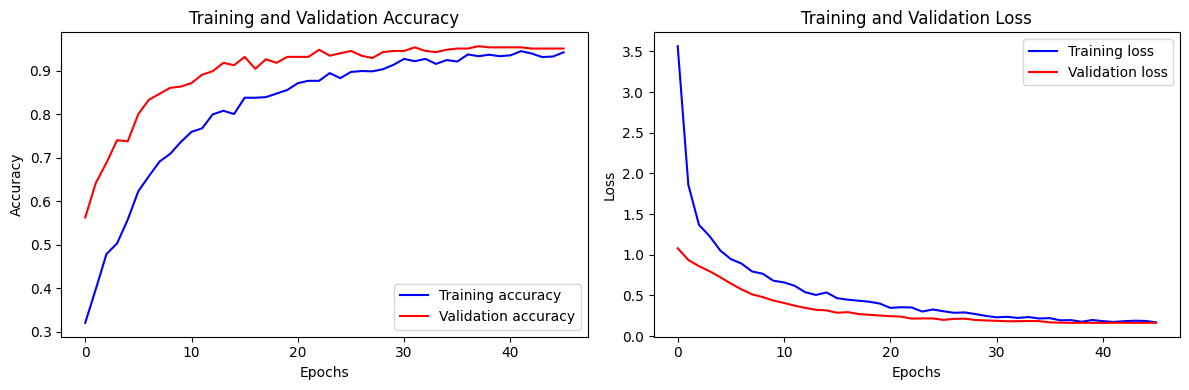

In [ ]:
# Plot training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Classification report
y_pred_prob = model.predict(test_images)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(test_images.classes, y_pred)
print("\nClassification Report:")
print(classification_report(test_images.classes, y_pred, target_names=['jahe', 'kencur', 'kunyit', 'lengkuas'],digits=4))

15/15 [==============================] - 12s 697ms/step

Classification Report:
              precision    recall  f1-score   support

        jahe     0.9254    0.9764    0.9502       127
      kencur     0.9615    0.9709    0.9662       103
      kunyit     0.9831    0.9431    0.9627       123
    lengkuas     0.9903    0.9623    0.9761       106

    accuracy                         0.9630       459
   macro avg     0.9651    0.9632    0.9638       459
weighted avg     0.9639    0.9630    0.9631       459



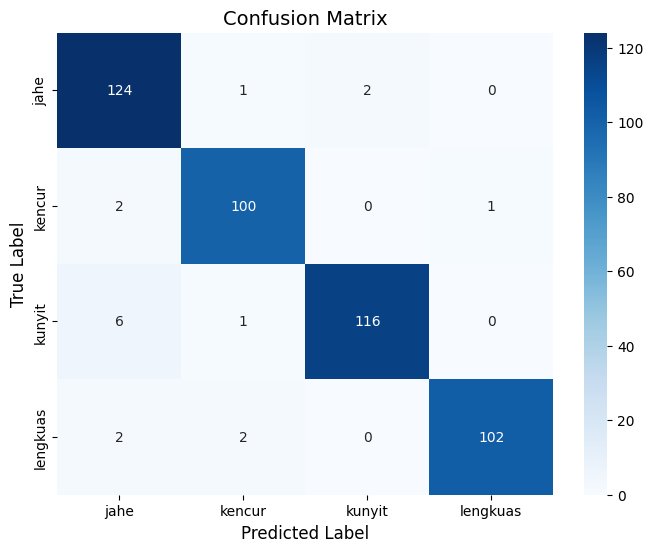

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['jahe', 'kencur', 'kunyit', 'lengkuas'],
            yticklabels=['jahe', 'kencur', 'kunyit', 'lengkuas'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()